In [ ]:
import warnings
warnings.simplefilter('ignore')

import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display
# import skillsnetwork
# print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm


tensorflow version: 2.15.0


In [ ]:
def plot_array(X,title=""):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

In [ ]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"

In [ ]:
import requests

def download_file(url, filename=None):
  response = requests.get(url, stream=True)


  if response.status_code == 200:

    if "content-disposition" in response.headers:
      content_disposition = response.headers["content-disposition"]
      filename = content_disposition.split("filename=")[1].strip('"')
    else:

      filename = url.split("/")[-1]


    with open(filename, "wb") as file:

      for chunk in response.iter_content(1024):
        if chunk:  # filter out keep-alive new chunks
          file.write(chunk)
    print(f"Downloaded file: {filename}")
  else:
    print(f"Download failed: {response.status_code}")

# Example usage
# url = "https://docs.google.com/fileview?id=0B1HXnM1lBuoqMzVhZjcwNTAtZWI5OS00ZDg3LWEyMzktNzZmYWY2Y2NhNWQx&hl=en"  # Replace with your desired URL
download_file(dataset_url)

Downloaded file: cartoon_20000.zip


In [ ]:
import zipfile

def unzip_file(zip_filename, output_dir):
  with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(output_dir)
    print(f"Extracted contents of {zip_filename} to {output_dir}")

zip_filename = "cartoon_20000.zip"
output_dir = "cartoon_20000"

unzip_file(zip_filename, output_dir)


Extracted contents of cartoon_20000.zip to cartoon_20000


In [ ]:
img_height, img_width, batch_size=64,64,128
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000', # change directory to 'cartoon_data' if you use the full dataset
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)

Found 20000 files belonging to 1 classes.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

In [ ]:
images=train_ds.take(1)

In [ ]:
X=[x for x in images]

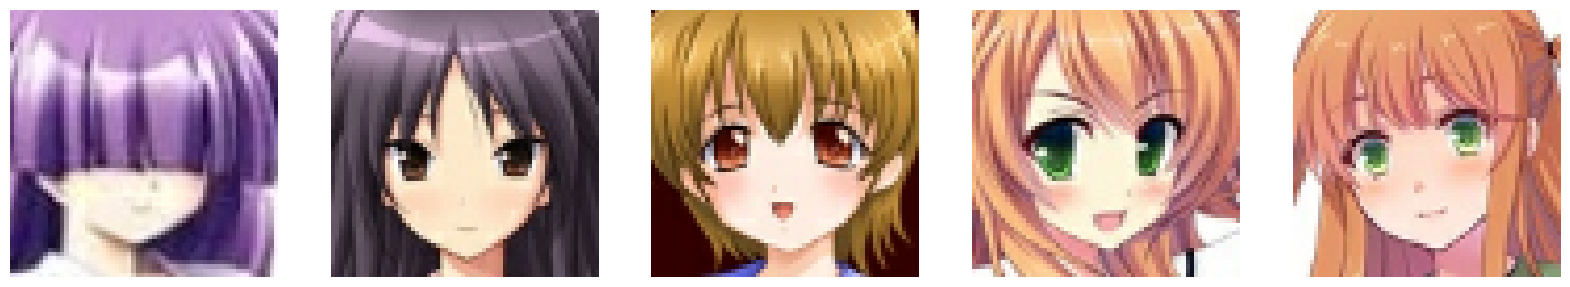

In [ ]:
plot_array(X[0])

##  Generator and Discriminator


### Building the Generator


In [ ]:
def make_generator():

    model=Sequential()

    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))

    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))


    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                              activation='tanh', name='conv_transpose_5'))

    return model

In [ ]:
gen = make_generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_transpose_1 (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 bn_1 (BatchNormalization)   (None, 4, 4, 512)         2048      
                                                                 
 relu_1 (ReLU)               (None, 4, 4, 512)         0         
                                                                 
 conv_transpose_2 (Conv2DTr  (None, 8, 8, 256)         2097152   
 anspose)                                                        
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                                 
 relu_2 (ReLU)               (None, 8, 8, 256)         0

### Building the Discriminator


In [ ]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

In [ ]:
disc = make_discriminator()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 128)       131072    
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 128)       512       
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)        

## Defining Loss Functions

As we discussed in the previous lab, the min-max optimization problem can be formulated by minimizing the cross entropy loss for the Generator and Discriminator.  

The `cross_entropy` object is the Binary Cross Entropy loss that will be used to model the objectives of the two networks.


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [ ]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

## Defining Optimizers

We create two Adam optimizers for the discriminator and the generator, respectively. We pass the following arguments to the optimizers:

- learning rate of 0.0002.
- beta coefficients $\beta_1 = 0.5$ and $\beta_2 = 0.999$, which are responsible for computing the running averages of the gradients during backpropagation.


In [ ]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

## Create Train Step Function

As this lab is more computationally intensive than the last lab, we convert the training step into a function and then use the  @tf.function decorator, which allows the function to be "compiled" into a **callable TensorFlow graph**. This will speed up the training; for more information, read <a href="https://www.tensorflow.org/guide/function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">here </a>


In [ ]:
@tf.function

def train_step(X):

    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)

        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

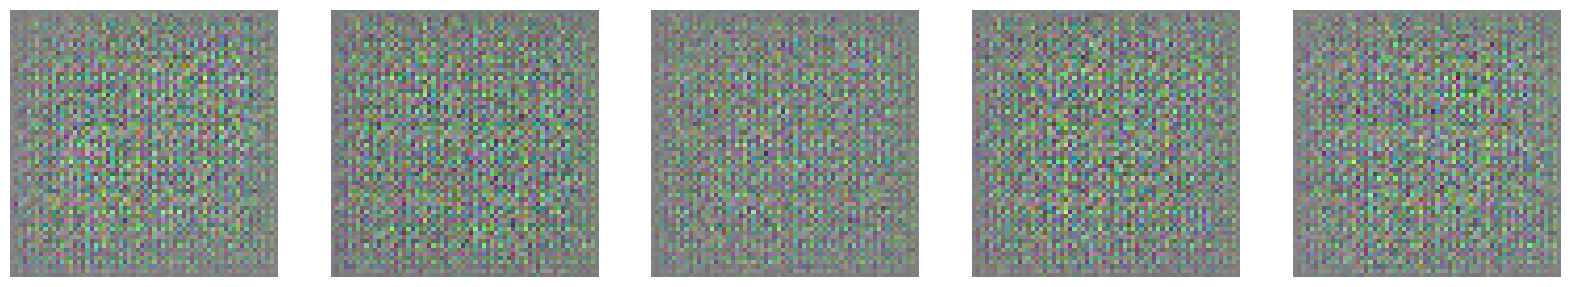

In [ ]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

## Training the Model


epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1, iteration 1
epoch 1, iteration 2
epoch 1, iteration 3
epoch 1, iteration 4
epoch 1, iteration 5
epoch 1, iteration 6
epoch 1, iteration 7
epoch 1, iteration 8
epoch 1, iteration 9
epoch 1, iteration 10
epoch 1, iteration 11
epoch 1, iteration 12
epoch 1, iteration 13
epoch 1, iteration 14
epoch 1, iteration 15
epoch 1, iteration 16
epoch 1, iteration 17
epoch 1, iteration 18
epoch 1, iteration 19
epoch 1, iteration 20
epoch 1, iteration 21
epoch 1, iteration 22
epoch 1, iteration 23
epoch 1, iteration 24
epoch 1, iteration 25
epoch 1, iteration 26
epoch 1, iteration 27
epoch 1, iteration 28
epoch 1, iteration 29
epoch 1, iteration 30
epoch 1, iteration 31
epoch 1, iteration 32
epoch 1, iteration 33
epoch 1, iteration 34
epoch 1, iteration 35
epoch 1, iteration 36
epoch 1, iteration 37
epoch 1, iteration 38
epoch 1, iteration 39
epoch 1, iteration 40
epoch 1, iteration 41
epoch 1, iteration 42
epoch 1, iteration 43
epoch 1, iteration 44
epoch 1, iteration 45
epoch 1, iteration 

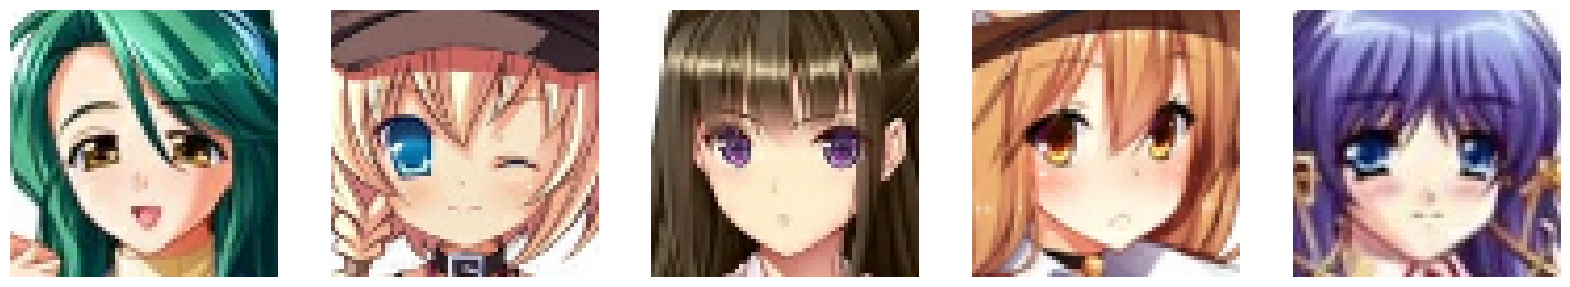

generated images


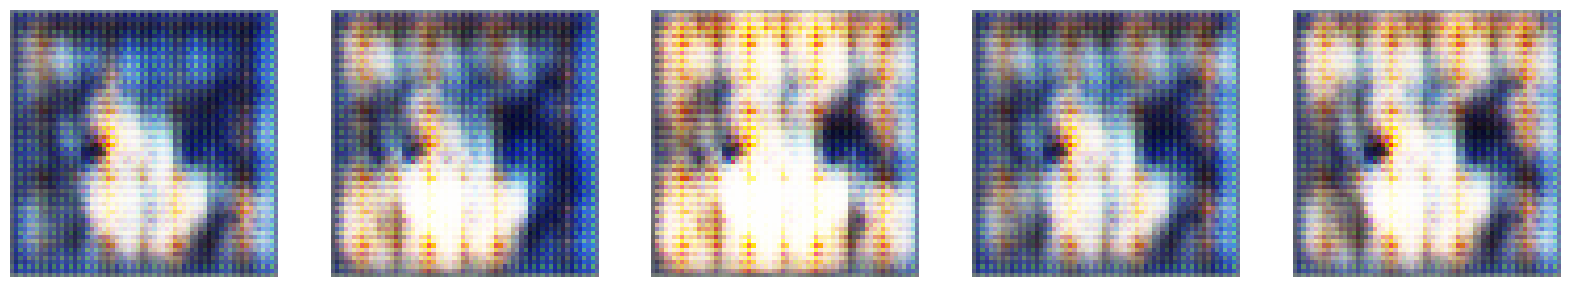

Time for epoch 1 is 1344.63014793396 sec


In [ ]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):

    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):

        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))

        train_step(X)


    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
generator_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.tar.gz"

In [ ]:
download_file(generator_url)

Downloaded file: generator.tar.gz


In [ ]:
import tarfile

def unzip_file(zip_filename, output_dir):
    with tarfile.open(zip_filename, mode="r:gz") as tf:
        tf.extractall(output_dir)

zip_filename = "generator.tar.gz"
output_dir = "generator"
unzip_file(zip_filename, output_dir)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
full_generator=load_model("/content/generator/generator/saved_model.pb")

OSError: Unable to open file (file signature not found)